### Dependences

In [1]:
import sys
sys.path.append("../")

import math
from tqdm import tqdm
import numpy as np
import tensorflow as tf

from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
from IPython.display import clear_output

from lib.models.UNet import UNet
import lib.utils as utils

import IPython.display as ipd


### Loading experiment data

In [2]:
#set experiment ID
EXP_ID = "UNet"
utils.create_experiment_folders(EXP_ID)
utils.load_experiment_data()


### Model instantiation

In [3]:
model = UNet()
model.build((None,128,128,1))
print(model.summary())


Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 32)      448       
_________________________________________________________________
sequential_1 (Sequential)    (None, 64, 64, 64)        18752     
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 128)       74368     
_________________________________________________________________
sequential_3 (Sequential)    (None, 16, 16, 256)       296192    
_________________________________________________________________
sequential_4 (Sequential)    (None, 8, 8, 512)         1182208   
_________________________________________________________________
sequential_5 (Sequential)    (None, 4, 4, 1024)        472371

### Loading Dataset

In [6]:
train_x = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_train.npy", mmap_mode='c') 
train_y = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_train.npy", mmap_mode='c') 

qtd_traning = train_x.shape
print("Loaded",qtd_traning, "samples")


Loaded (371026, 128, 128, 1) samples


In [4]:
valid_x_1 = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_val.npy", mmap_mode='c') 
valid_y_1 = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_val.npy", mmap_mode='c')

# valid_x_2 = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_val_2.npy", mmap_mode='c') 
# valid_y_2 = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_val_2.npy", mmap_mode='c')

# valid_x_3 = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_val_3.npy", mmap_mode='c') 
# valid_y_3 = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_val_3.npy", mmap_mode='c') 


qtd_traning = valid_x_1.shape
print("Loaded",qtd_traning, "samples")


Loaded (92800, 128, 128, 1) samples


### Dataset Normalization and Batches split

In [7]:
# print(np.amin(train_x), np.amax(train_x))

value = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/scale_and_shift.npy", mmap_mode='c') 
print(value)
SHIFT_VALUE_X, SHIFT_VALUE_Y, SCALE_VALUE_X, SCALE_VALUE_Y = value[0], value[1], value[2], value[3]
# SHIFT_VALUE_X, SHIFT_VALUE_Y, SCALE_VALUE_X, SCALE_VALUE_Y = utils.get_shift_scale_maxmin(train_x, train_y, valid_x_1, valid_y_1)

# train_x = utils.shift_and_normalize(train_x, SHIFT_VALUE_X, SCALE_VALUE_X)
# train_y = utils.shift_and_normalize(train_y, SHIFT_VALUE_Y, SCALE_VALUE_Y)
# print("TRAIN NORMALIZED")

# valid_x_1 = utils.shift_and_normalize(valid_x_1, SHIFT_VALUE_X, SCALE_VALUE_X)
# valid_y_1 = utils.shift_and_normalize(valid_y_1, SHIFT_VALUE_Y, SCALE_VALUE_Y)
# print("VAL 1 NORMALIZED")

# valid_x_2 = utils.shift_and_normalize(valid_x_2, SHIFT_VALUE_X, SCALE_VALUE_X)
# valid_y_2 = utils.shift_and_normalize(valid_y_2, SHIFT_VALUE_Y, SCALE_VALUE_Y)
# print("VAL 2 NORMALIZED")

# valid_x_3 = utils.shift_and_normalize(valid_x_3, SHIFT_VALUE_X, SCALE_VALUE_X)
# valid_y_3 = utils.shift_and_normalize(valid_y_3, SHIFT_VALUE_Y, SCALE_VALUE_Y)
# print("VAL 3 NORMALIZED")

# print(np.amin(train_x), np.amax(train_x))


# train_batches = utils.random_mini_batches(train_x, train_y, None, None, 8, seed=0)

# valid_batches_1 = utils.random_mini_batches(valid_x_1, valid_y_1, None, None, 8, seed=0)
# valid_batches_2 = utils.random_mini_batches(valid_x_2, valid_y_2, None, None, 8, seed=0)
# valid_batches_3 = utils.random_mini_batches(valid_x_3, valid_y_3, None, None, 8, seed=0)
mini_batch_size = 58
num_train_minibatches = math.floor(train_x.shape[0]/mini_batch_size)
num_val_minibatches = math.floor(valid_x_1.shape[0]/mini_batch_size)



print("train_batches:", num_train_minibatches, "valid_batches:", num_val_minibatches)


# print("Preview examples from train set")
# for index,batch in enumerate(train_batches):
#     if index > 1:
#         break
#     (seismic_x, seismic_y, _, _) = batch
#     print("batch", index)
#     plt.imshow( np.hstack((seismic_x[0,:,:,0], seismic_y[0,:,:,0])) , cmap='Spectral', vmin=0, vmax=1)
#     plt.axis('off')
#     plt.pause(0.1)
    


[ -0.          -0.         127.97928619 127.98652649]
train_batches: 6397 valid_batches: 1600


In [ ]:
# print(SHIFT_VALUE_X)
# print(SHIFT_VALUE_Y)
# print(SCALE_VALUE_X)
# print(SCALE_VALUE_Y)
# value = np.array([SHIFT_VALUE_X, SHIFT_VALUE_Y, SCALE_VALUE_X, SCALE_VALUE_Y])
# np.save("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/scale_and_shift.npy",value)

### Metrics

In [8]:
#default tf.keras metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')

### Set Loss and load model weights

In [9]:
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#get last saved epoch index and best result in validation step
CURRENT_EPOCH, BEST_VALIDATION = utils.get_model_last_data()
if CURRENT_EPOCH > 0:
    print("Loading last model state in epoch", CURRENT_EPOCH)
    model.load_weights(utils.get_exp_folder_last_epoch())
    print("Best validation result was PSNR=", BEST_VALIDATION)

Loading last model state in epoch 100
Best validation result was PSNR= 55.76866229443484


### Training

In [ ]:
@tf.function
def train_step(patch_x, patch_y):
    with tf.GradientTape() as tape:
        predictions = model(patch_x)
        loss = loss_object(patch_y, predictions)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)

def valid_step(valid_x, valid_y, num_val_minibatches, mini_batch_size):
    valid_mse = tf.keras.metrics.MeanSquaredError(name='train_mse')
    valid_custom_metrics = utils.CustomMetric()
    for i in tqdm(range(num_val_minibatches)):
        data_x = valid_x[i * mini_batch_size : i * mini_batch_size + mini_batch_size]
        data_y = valid_y[i * mini_batch_size : i * mini_batch_size + mini_batch_size]
        
        data_x = tf.convert_to_tensor(data_x, dtype=tf.float32)
        data_y = tf.convert_to_tensor(data_y, dtype=tf.float32)
        
        data_x = ((data_x+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA
        data_y = ((data_y+SHIFT_VALUE_Y)/SCALE_VALUE_Y)+CONST_GAMA
        
        predictions = model(data_x)
        valid_mse(data_y, predictions)

        predictions = predictions.numpy()
        data_y = data_y.numpy()
        
        #feed the metric evaluator
        valid_custom_metrics.feed(data_y, predictions)

        #just show the first example of the first batch
#         if i == 0:
#             print("Spatial domain: X - Y - PREDICT")
#             plt.imshow(np.hstack((data_x[0,:,:,0], data_y[0,:,:,0], predictions[0,:,:,0])) , cmap='Spectral', vmin=0, vmax=1)
#             plt.axis('off')
#             plt.pause(0.1)
    
    #get metric results
    psnr, nrmse = valid_custom_metrics.result()
    valid_mse_result = valid_mse.result().numpy()
    valid_custom_metrics.reset_states()
    valid_mse.reset_states()
    return psnr, nrmse, valid_mse_result
    
MAX_EPOCHS = 100
EVAL_STEP = 1
CONST_GAMA = 0.001


for epoch in range(CURRENT_EPOCH, MAX_EPOCHS):
    
    #TRAINING
    print("TRAINING EPOCH", epoch)
   
    #for batch in train_batches:
        #(seismic_x, seismic_y, _, _) = batch
        #train_step(seismic_x, seismic_y)
    for k in tqdm(range(0, num_train_minibatches)):
        seismic_x = train_x[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        seismic_y = train_y[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        
        seismic_x = tf.convert_to_tensor(seismic_x, dtype=tf.float32)
        seismic_y = tf.convert_to_tensor(seismic_y, dtype=tf.float32)
        
        seismic_x = ((seismic_x+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA
        seismic_y = ((seismic_y+SHIFT_VALUE_Y)/SCALE_VALUE_Y)+CONST_GAMA
        
        train_step(seismic_x, seismic_y)
        
    #VALIDATION
    if epoch%EVAL_STEP == 0:
        clear_output()
        
        print("VALIDATION EPOCH", epoch)
        #saving last epoch model
        model.save_weights(utils.get_exp_folder_last_epoch(), save_format='tf')
       
        #valid with set 1
        print("Validation set")
        psnr_1, nrmse_1, mse_1 = valid_step(valid_x_1, valid_y_1, num_val_minibatches, mini_batch_size)
        
        #valid with set 2
        #print("Validation set 2")
        #psnr_2, nrmse_2, mse_2 = valid_step(valid_x_2, valid_y_2, num_val_minibatches, mini_batch_size)
        psnr_2, nrmse_2, mse_2 = 0, 0, 0
        
        #valid with set 3
        #print("Validation set 3")
        #psnr_3, nrmse_3, mse_3 = valid_step(valid_x_3, valid_y_3, num_val_minibatches, mini_batch_size)
        psnr_3, nrmse_3, mse_3 = 0, 0, 0
        
        utils.update_chart_data(epoch=epoch, train_mse=train_loss.result().numpy(), 
                                valid_mse=[mse_1,mse_2,mse_3], psnr=[psnr_1,psnr_2,psnr_3], nrmse=[nrmse_1,nrmse_2, nrmse_3])
        utils.draw_chart()
        
        #saving best validation model
        if psnr_1 > BEST_VALIDATION:
            BEST_VALIDATION = psnr_1
            model.save_weights(utils.get_exp_folder_best_valid(), save_format='tf')
        
    train_loss.reset_states()


  0%|          | 0/6397 [00:00<?, ?it/s]

TRAINING EPOCH 0


 23%|██▎       | 1488/6397 [05:04<17:21,  4.71it/s]

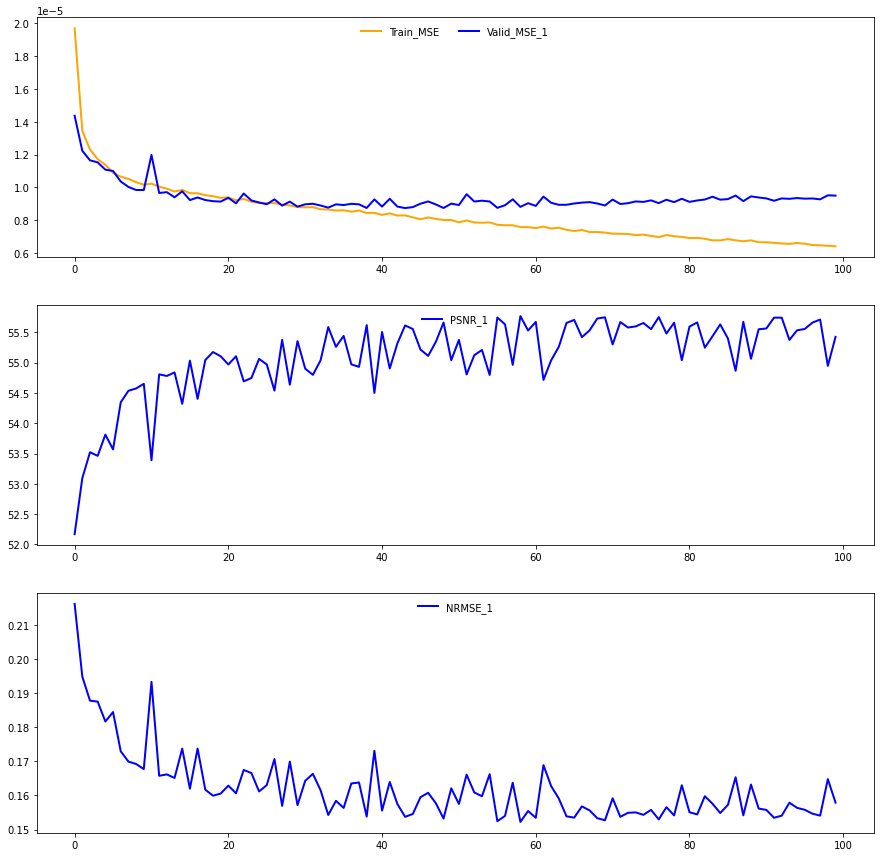

In [6]:
utils.draw_chart()

In [12]:
#experimentos results
print(utils.get_experiment_results())

{'Best_Valid': 55.76866229443484, 'Best_Epoch': 58, 'PSNR_1': 55.76866229443484, 'PSNR_2': 0, 'PSNR_3': 0, 'NRMSE_1': 0.15225267935306475, 'NRMSE_2': 0, 'NRMSE_3': 0}


In [12]:
#load best model
model.load_weights(utils.get_exp_folder_best_valid())
CONST_GAMA = 0.001

qtd_traning = valid_x_1.shape
print("Loaded",qtd_traning, "samples")

#batches
num_val_minibatches = math.floor(valid_x_1.shape[0]/mini_batch_size)

#metrics
val_mse = tf.keras.metrics.MeanSquaredError(name='val_mse')
val_custom_metrics = utils.CustomMetric()

import json
f = open('/home/arthursrr/Documentos/Audio_Inpainting/Datasets/idx_genders_val.json', "r") 
idx_gen = json.loads(f.read()) 

for k in idx_gen:
    for i in tqdm(idx_gen[k]):
        data_x = valid_x_1[i * mini_batch_size : i * mini_batch_size + mini_batch_size]
        data_y = valid_y_1[i * mini_batch_size : i * mini_batch_size + mini_batch_size]

        data_x = tf.convert_to_tensor(data_x, dtype=tf.float32)
        data_y = tf.convert_to_tensor(data_y, dtype=tf.float32)

        data_x = ((data_x+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA
        data_y = ((data_y+SHIFT_VALUE_Y)/SCALE_VALUE_Y)+CONST_GAMA

        predictions = model(data_x)
        val_mse(data_y, predictions)

        predictions = predictions.numpy()
        data_y = data_y.numpy()

        #feed the metric evaluator
        val_custom_metrics.feed(data_y, predictions)

    #get metric results
    psnr, nrmse = val_custom_metrics.result()
    val_mse_result = val_mse.result().numpy()
    val_custom_metrics.reset_states()
    val_mse.reset_states()
    
    print(k ,"\nPSNR:", psnr,"\nNRMSE:", nrmse)

# Closing file 
f.close() 

  0%|          | 1/200 [00:00<00:22,  8.84it/s]

Loaded (92800, 128, 128, 1) samples


  0%|          | 1/200 [00:00<00:31,  6.30it/s]

Electronic 
PSNR: 53.675969579799826 
NRMSE: 0.15403550572748942


  0%|          | 1/200 [00:00<00:31,  6.39it/s]

Experimental 
PSNR: 57.35306203391649 
NRMSE: 0.15791295737850722


  0%|          | 1/200 [00:00<00:34,  5.72it/s]

Rock 
PSNR: 52.603043555796894 
NRMSE: 0.1704554835478083


  0%|          | 1/200 [00:00<00:34,  5.83it/s]

Hip-Hop 
PSNR: 52.971589355387096 
NRMSE: 0.1530762464273442


  0%|          | 1/200 [00:00<00:21,  9.19it/s]

Folk 
PSNR: 58.090851038509555 
NRMSE: 0.13953886465568435


  0%|          | 1/200 [00:00<00:22,  8.76it/s]

Instrumental 
PSNR: 59.01351123605945 
NRMSE: 0.14540292247051087


  0%|          | 0/200 [00:00<?, ?it/s]

Pop 
PSNR: 54.90137497389161 
NRMSE: 0.15563638402301017


100%|██████████| 200/200 [00:22<00:00,  8.72it/s]

International 
PSNR: 57.53989659053112 
NRMSE: 0.14196307065848796


## Test

In [13]:
#load best model
model.load_weights(utils.get_exp_folder_best_valid())

test_x = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_test.npy", mmap_mode='c') 
test_y = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_test.npy", mmap_mode='c')

qtd_traning = test_x.shape
print("Loaded",qtd_traning, "samples")

# #normalization
# test_x = utils.shift_and_normalize(test_x, SHIFT_VALUE_X, SCALE_VALUE_X)
# test_y = utils.shift_and_normalize(test_y, SHIFT_VALUE_Y, SCALE_VALUE_Y) 

#batches
num_test_minibatches = math.floor(test_x.shape[0]/mini_batch_size)
# test_batches = utils.random_mini_batches(test_x, test_y, None, None, 8, seed=0)

#metrics
test_mse = tf.keras.metrics.MeanSquaredError(name='train_mse')
test_custom_metrics = utils.CustomMetric()

#test
for i in tqdm(range(num_test_minibatches)):
    data_x = test_x[i * mini_batch_size : i * mini_batch_size + mini_batch_size]
    data_y = test_y[i * mini_batch_size : i * mini_batch_size + mini_batch_size]

    data_x = tf.convert_to_tensor(data_x, dtype=tf.float32)
    data_y = tf.convert_to_tensor(data_y, dtype=tf.float32)

    data_x = ((data_x+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA
    data_y = ((data_y+SHIFT_VALUE_Y)/SCALE_VALUE_Y)+CONST_GAMA

    predictions = model(data_x)
    test_mse(data_y, predictions)

    predictions = predictions.numpy()
    data_y = data_y.numpy()

    #feed the metric evaluator
    test_custom_metrics.feed(data_y, predictions)

    #just show the first example of each batch until 5    
#     print("Spatial domain: X - Y - PREDICT - DIFF")
#     plt.imshow(np.hstack((data_x[0,:,:,0], data_y[0,:,:,0], predictions[0,:,:,0], np.abs(predictions[0,:,:,0]-seismic_y[0,:,:,0]))) , cmap='Spectral', vmin=0, vmax=1)
#     plt.axis('off')
#     plt.pause(0.1)
    
    #ATENÇÃO!!
    
    #predictions = inv_shift_and_normalize(predictions, SHIFT_VALUE_Y, SCALE_VALUE_Y)
    #np.save(outfile_path, predictions)
    
#get metric results
psnr, nrmse = test_custom_metrics.result()
test_mse_result = test_mse.result().numpy()
test_custom_metrics.reset_states()
test_mse.reset_states()
    
print("PSNR:", psnr,"\nNRMSE", nrmse)

 


  0%|          | 1/5586 [00:00<14:42,  6.33it/s]

Loaded (323988, 128, 128, 1) samples


100%|██████████| 5586/5586 [16:21<00:00,  5.69it/s]

PSNR: 58.01885833869823 
NRMSE 0.14688873454443294


In [11]:
import json
f = open ('/home/arthursrr/Documentos/Audio_Inpainting/Datasets/idx_genders_test.json', "r") 
idx_gen = json.loads(f.read()) 

for k in idx_gen:
    for i in tqdm(idx_gen[k]):
        data_x = test_x[i * mini_batch_size : i * mini_batch_size + mini_batch_size]
        data_y = test_y[i * mini_batch_size : i * mini_batch_size + mini_batch_size]

        data_x = tf.convert_to_tensor(data_x, dtype=tf.float32)
        data_y = tf.convert_to_tensor(data_y, dtype=tf.float32)

        data_x = ((data_x+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA
        data_y = ((data_y+SHIFT_VALUE_Y)/SCALE_VALUE_Y)+CONST_GAMA

        predictions = model(data_x)
        test_mse(data_y, predictions)

        predictions = predictions.numpy()
        data_y = data_y.numpy()

        #feed the metric evaluator
        test_custom_metrics.feed(data_y, predictions)

    #get metric results
    psnr, nrmse = test_custom_metrics.result()
    test_mse_result = test_mse.result().numpy()
    test_custom_metrics.reset_states()
    test_mse.reset_states()
    
    print(k ,"\nPSNR:", psnr,"\nNRMSE:", nrmse)

# Closing file 
f.close() 

  0%|          | 0/638 [00:00<?, ?it/s]

Loaded (323988, 128, 128, 1) samples


  0%|          | 1/625 [00:00<01:08,  9.17it/s]

Electronic 
PSNR: 53.80803716251571 
NRMSE: 0.15639691268477152


  0%|          | 1/619 [00:00<01:08,  9.04it/s]

Experimental 
PSNR: 57.80713039810737 
NRMSE: 0.15802904439924706


  0%|          | 1/609 [00:00<01:07,  9.07it/s]

Classical 
PSNR: 67.61025287985736 
NRMSE: 0.12063635320408712


  0%|          | 1/585 [00:00<00:59,  9.83it/s]

Rock 
PSNR: 53.062168989428315 
NRMSE: 0.17127020423389994


  0%|          | 1/518 [00:00<00:54,  9.43it/s]

Hip-Hop 
PSNR: 53.29808016620869 
NRMSE: 0.15352712667782512


  0%|          | 2/510 [00:00<00:48, 10.49it/s]

Folk 
PSNR: 58.66462988155243 
NRMSE: 0.13873919769306658


  0%|          | 1/384 [00:00<00:42,  9.02it/s]

Old-Time / Historic 
PSNR: 63.52334964364615 
NRMSE: 0.12082024949076353


  0%|          | 1/349 [00:00<00:38,  9.13it/s]

Jazz 
PSNR: 59.62396677016127 
NRMSE: 0.14003725945680678


  1%|          | 1/186 [00:00<00:20,  9.13it/s]

Instrumental 
PSNR: 57.97113027274935 
NRMSE: 0.15041520142218257


  1%|          | 1/178 [00:00<00:19,  9.22it/s]

Pop 
PSNR: 55.36451249901345 
NRMSE: 0.15760446441055193


  1%|▏         | 2/154 [00:00<00:15, 10.10it/s]

Country 
PSNR: 54.98152131813077 
NRMSE: 0.15608996587311855


  1%|          | 1/118 [00:00<00:13,  8.91it/s]

Soul-RnB 
PSNR: 52.90441520702654 
NRMSE: 0.16050688042293076


  1%|▏         | 1/74 [00:00<00:07,  9.21it/s]

Spoken 
PSNR: 64.31614368212401 
NRMSE: 0.12985783112368404


  5%|▍         | 1/21 [00:00<00:02,  9.10it/s]

Blues 
PSNR: 57.61068355248837 
NRMSE: 0.14658288153257643


  6%|▌         | 1/18 [00:00<00:01,  9.57it/s]

Easy Listening 
PSNR: 56.80752989206669 
NRMSE: 0.14619471038348808


100%|██████████| 18/18 [00:02<00:00,  8.98it/s]

International 
PSNR: 61.07867127751254 
NRMSE: 0.13160375370327518


In [14]:
def griffin_lim(S, frame_length=256, fft_length=255, stride=64):
    '''
    TensorFlow implementation of Griffin-Lim
    Based on https://github.com/Kyubyong/tensorflow-exercises/blob/master/Audio_Processing.ipynb
    '''
    S = tf.expand_dims(S, 0)
    S_complex = tf.identity(tf.cast(S, dtype=tf.complex64))
    y = tf.signal.inverse_stft(S_complex, frame_length, stride, fft_length=fft_length)
    for i in range(1000):
        est = tf.signal.stft(y, frame_length, stride, fft_length=fft_length)
        angles = est / tf.cast(tf.maximum(1e-16, tf.abs(est)), tf.complex64)
        y = tf.signal.inverse_stft(S_complex * angles, frame_length, stride, fft_length=fft_length)
    return tf.squeeze(y, 0)

In [15]:
model.load_weights(utils.get_exp_folder_best_valid())

test_x = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/X_test.npy", mmap_mode='c') 
test_y = np.load("/mnt/backup/arthur/Free_Music_Archive/Spectrogramas/y_test.npy", mmap_mode='c')

qtd_traning = test_x.shape
print("Loaded",qtd_traning, "samples")

#batches
num_test_minibatches = math.floor(test_x.shape[0]/mini_batch_size)

#metrics
test_mse = tf.keras.metrics.MeanSquaredError(name='train_mse')
test_custom_metrics = utils.CustomMetric()

i=2000
CONST_GAMA = 0.001

data_x = test_x[i * mini_batch_size : i * mini_batch_size + mini_batch_size]
data_y = test_y[i * mini_batch_size : i * mini_batch_size + mini_batch_size]

data_x = tf.convert_to_tensor(data_x, dtype=tf.float32)

data_norm = ((data_x+SHIFT_VALUE_X)/SCALE_VALUE_X)+CONST_GAMA

predictions = model(data_norm)

predictions = utils.inv_shift_and_normalize(predictions, SHIFT_VALUE_Y, SCALE_VALUE_Y)


Loaded (323988, 128, 128, 1) samples


In [16]:
predictions

<tf.Tensor: shape=(58, 128, 128, 1), dtype=float32, numpy=
array([[[[ 1.37758970e-01],
         [ 1.27153718e+00],
         [ 4.18731833e+00],
         ...,
         [ 2.99372897e-02],
         [ 4.58716899e-02],
         [ 2.18339823e-02]],

        [[ 2.70051539e-01],
         [ 1.04952252e+00],
         [ 7.70495462e+00],
         ...,
         [ 3.28840427e-02],
         [ 3.76549959e-02],
         [ 7.20815659e-02]],

        [[ 2.18112767e-01],
         [ 1.85037279e+00],
         [ 8.96309471e+00],
         ...,
         [ 1.61735527e-02],
         [-2.70870118e-03],
         [ 6.00381605e-02]],

        ...,

        [[ 2.49374866e+00],
         [ 8.84296513e+00],
         [ 7.77268887e+00],
         ...,
         [ 2.83343624e-02],
         [ 8.04536417e-02],
         [ 1.07950009e-01]],

        [[ 3.19865704e+00],
         [ 8.18018723e+00],
         [ 1.14070234e+01],
         ...,
         [ 3.30781974e-02],
         [ 4.33605276e-02],
         [ 1.08759500e-01]],

       

In [17]:
audio_pred = None
for i in range(0, 58):
    if i==0:
        audio_pred = predictions[i,:,:,0]
    else:
        audio_pred = np.concatenate((audio_pred, predictions[i,:,:,0]), axis=0)
audio_pred.shape

(7424, 128)

In [18]:
audio_corte = None
for i in range(0, 58):
    if i==0:
        audio_corte = data_x[i,:,:,0]
    else:
        audio_corte = np.concatenate((audio_corte, data_x[i,:,:,0]), axis=0)
audio_corte.shape

(7424, 128)

In [19]:
audio_original = None
for i in range(0, 58):
    if i==0:
        audio_original = data_y[i,:,:,0]
    else:
        audio_original = np.concatenate((audio_original, data_y[i,:,:,0]), axis=0)
audio_original.shape

(7424, 128)

In [20]:
wave_original = griffin_lim(audio_original, frame_length=256, fft_length=255, stride=64)
ipd.Audio(wave_original, rate=16000)

In [21]:
wave_corte = griffin_lim(audio_corte, frame_length=256, fft_length=255, stride=64)
ipd.Audio(wave_corte, rate=16000)

In [22]:
wave_pred = griffin_lim(audio_pred, frame_length=256, fft_length=255, stride=64)
ipd.Audio(wave_pred, rate=16000)

In [ ]:
import soundfile as sf
sf.write('x.wav', wave_corte, 16000, subtype='PCM_16')
sf.write('pred.wav', wave_pred, 16000, subtype='PCM_16')